# Notebook for Generating CCap Interpolation Files

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import time

from scipy import interpolate
import scipy.integrate as integrate
import matplotlib.pyplot as plt
%matplotlib inline

print ('Complete')

Complete


In [2]:
################################################################################
# Conversions
################################################################################

def Gev2Tev(par1):
    return par1*10**-3

def amu2Gev(par1):
#     return 0.9314941 * par1 # GeV
    return 0.938272 * par1 # Taken directly from Flip notebook

def amu2g(par1):
    return 1.66053892e-24 * par1 # g

def GeV2s(par1):
    return 1.52*10**24 * par1 # s^-1

def s2GeV(par1):
#     return 1.52*10**24 * par1 # GeV^-1
    return (6.58e-25)**-1 * par1 # GeV^-1

def GeV2cm(par1):
    return 5.06*10**13 * par1 # cm^-1

def cm2GeV(par1):
#     return 5.06*10**13 * par1 # GeV^-1
    return (0.197e-13)**-1 * par1 # GeV^-1

def KeltoGeV(par1):
    return 8.62*10**-14 * par1 # GeV

def yr2s(par1):
    return (3.16888*10**-8)**-1 * par1 # s

def ev2Gev(par1):
    return par1 * 10**6 # GeV

def eV2kg(par1):
    return 1.782661845* 10**-36 * par1 # kg

def g2Gev(par1):
#     return 5.609588845*10**32 * par1 #GeV
    return (1.8e-24)**-1 * par1 #GeV

################################################################################
# Atomic Dictionary Definitions
################################################################################

elementList = [
    'O16' ,
    'Si28',
    'Mg24',
    'Fe56',
    'Ca40',
    'P31' ,
#     'Na11',
    'S32' ,
    'Ni58',
    'Al27',
    'Cr52',
]

# From http://www.chem.ualberta.ca/~massspec/atomic_mass_abund.pdf
isotopicMasses = {
    'O16': 15.994915 ,
    'Si28': 27.976927,
    'Mg24': 23.985042,
    'Fe56': 55.934942,
    'Ca40': 39.962591,
    'P31': 30.973762,
#     'Na11',
    'S32': 31.972071 ,
    'Ni58': 57.935348,
    'Al27': 26.981538,
    'Cr52': 51.940512,
}


atomicNumbers = {
    'H1': 1.,
    'He4': 4.,
    'He3': 3.,
    'Na11': 23.,
    'C12': 12.,
    'C13':13.,
    'N14':14.,
    'N15':15.,
    'O16':16.,
    'O17':17. ,
    'O18':18.,
    'Ne20':20.,
    'Na23':23.,
    'Mg24':24., # 78%
    'Al27':27.,
    'Si28':28.,
    'P31':30.,
    'S32':32.,
    'Cl35':35., # 75%
    'Ar40':40.,
    'K39':39.,
    'Ca40':40.,
    'Sc45':45.,
    'Ti48':48., # 74%
    'V51':51.,
    'Cr52':52., # 83%
    'Mn55':55.,
    'Fe56':56.,
    'Co59':59.,
    'Ni58':59., # 58%
}

nProtons = { # This is Z_N
    'H1':1.,
    'He3':2.,
    'He4':2.,
    'He3':2.,
    'Na11': 11.,
    'C12':6.,
    'C13':6.,
    'N14':7.,
    'N15':7.,
    'O16':8.,
    'O17':8.,
    'O18':8.,
    'Ne20':10.,
    'Na23':11.,
    'Mg24':12., # 78%
    'Al27':13.,
    'Si28':14.,
    'P31':15.,
    'S32':16.,
    'Cl35':17., # 75%
    'Ar40':18.,
    'K39':19.,
    'Ca40':20.,
    'Sc45':21.,
    'Ti48':22., # 74%
    'V51':23.,
    'Cr52':24., # 83%
    'Mn55':25.,
    'Fe56':26.,
    'Co59':27.,
    'Ni58':28., # 58%
}

# Mass Fraction Dictionary
coreMassFrac = {
    'Na11': 0.0,
    'O16' : 0.0,
    'Mg24': 0.0,
    'Al27': 0.0,
    'Si28': 0.06,
    'P31' : 0.002,
    'S32' : 0.019,
    'Ca40': 0.0,
    'Cr52': 0.009,
    'Fe56': 0.855,
    'Ni58': 0.052,
}

mantleMassFrac = {
    'Na11': 0.0027,
    'O16' : 0.440,
    'Mg24': 0.228,
    'Al27': 0.0235,
    'Si28': 0.210,
    'P31' : 0.00009,
    'S32' : 0.00025,
    'Ca40': 0.0253,
    'Cr52': 0.0026,
    'Fe56': 0.0626,
    'Ni58': 0.00196,
}
print ('Complete')

Complete


In [3]:
################################################################################
# Constants
################################################################################
global c
global G
global M_E
global R_earth
global V_dot
global V_cross
global V_gal
global u_0
global k
global n_X
global mf

c = 3.0*10**10 # cm/s
G = 6.674e-11 * 100**3 *(1000)**-1 # cm^3/g s 
# M_E = 5.972e27 # g
# R_earth = 6.37e6 # m
V_dot = 220.0*10**5 # cm/s
V_cross = 298.0*10**5 # cm/s
V_gal = 550.0*10**5 # cm/s
u_0 = 245.0*10**5 # cm/s
k = 2.5

print ('Complete')

Complete


In [4]:

# Grab Data
data = pd.read_csv('PREM500.csv', sep = ',')
radiusTemp1 = data[[0]]  # Radius in Meters
densityTemp1 = data[[1]] # Density in kg/m^3
radiusListBadUnits = np.asarray(radiusTemp1).squeeze()
densityListBadUnits = np.asarray(densityTemp1).squeeze()

# Convert Units
radiusList = radiusListBadUnits * 100 # cm
densityList = densityListBadUnits * (100)**-3 * 1000 # g/cm^3




# DeltaR List
radius2 = radiusList[0:len(radiusList)-1]
s = [0]
for i in radius2:
    s.append(i)

deltaRList = radiusList[0:len(radiusList)] - s[0:len(s)]

xRange = range(0,len(radiusList))


# Shell Mass 
xRange = range(0,len(radiusList))

shellMassList = []
for i in xRange:
    shellMassList.append(4 * np.pi * radiusList[i]**2 * densityList[i] * deltaRList[i])

# Enclosed Mass
enclosedMassList = []
tempSum = 0
for i in shellMassList:
    tempSum = tempSum + i
    enclosedMassList.append(tempSum)
    


print ('Complete')

Complete


In [8]:
xRange = range(0,len(radiusList))
    
#########################
#Escape Velocity
#########################
def accumulate(index):
    factor = 2.*G/c**2
    constant = max(enclosedMassList) / max(radiusList)
    
    tempSum = 0    
    for i in range(index,len(radiusList)-1):
        summand = enclosedMassList[i] * deltaRList[i] / (radiusList[i])**2
        tempSum += summand
        
    return factor*(tempSum + constant)

escVel2List = []
for i in xRange:
    escVel2List.append(accumulate(i))



#########################
# Number Densities
##########################
range1 = range(0,len(radiusList))
mf = 0

def numDensityList(element): # returns GeV/cm^3 
    numDensityList = []
    for i in range1:
        if radiusList[i] < 348000000:
            mf = coreMassFrac[element]
        elif radiusList[i] >= 348000000:
            mf = mantleMassFrac[element]
        elif radiusList[i] > 348000000:
            mf = 0

#         n_i = mf *  densityList[i] / (amu2Gev(atomicNumbers[element])) * 6.02e23
        n_i = mf *  densityList[i] / (isotopicMasses[element]) * 6.02e23

        numDensityList.append(n_i)
        
    return numDensityList


#################
# List Interpolations
###################
enclosedMassInterp = interpolate.interp1d(radiusList,enclosedMassList,kind='linear') # kg
escVel2Interp = interpolate.interp1d(radiusList,escVel2List,kind='linear') # 1/c
densityInterp = interpolate.interp1d(radiusList,densityList,kind='linear') # kg/cm^3


#####################
#Form Factor
#####################
def formFactor2(element, E):
#     mn = amu2Gev(atomicNumbers[element])
    mn = isotopicMasses[element]
    E_N = 0.114/((atomicNumbers[element])**(5./3)) # in GeV
    FN2 = np.exp(-E/E_N)
    return FN2


######################
# Differnetial Cross Section with no constants
######################

def eqn09Guts(element, m_A, E): # returns 1/GeV^2
#     mn = amu2Gev(atomicNumbers[element])
    mn = isotopicMasses[element]
    function = (mn * formFactor2(element,E) ) / ((2*mn*E + m_A**2)**2)
    return function


#############################
# Velocity Distributions
#############################
# u is now a naturalized velocity
def DMVelDistNormalization(u):
# The if-else structure accounts for the Heaviside function
    if ((V_gal/c) - u < 0):
        temp = 0.
        
    elif ( ((V_gal/c) - (u)) >= 0):
        numerator = ((V_gal/c)**2 - (u)**2)
        denominator = (k * (u_0/c)**2)
        arg = ( numerator / denominator)    
        temp = 4*np.pi*(u)**2 * (np.expm1(arg))** k
    return temp


tempA = integrate.quad(DMVelDistNormalization,0,V_gal/c)[0]
N_0 = 1./tempA

def DMVelDist(u, N_1 = N_0):
# The if-else structure accounts for the Heaviside function
# N_1 is the normalization 
    if ((V_gal/c - u) < 0):
        temp = 0
        
    elif ((V_gal/c - u) >= 0):
        numerator = ((V_gal/c)**2 - (u)**2)
        denominator = (k * (u_0/c)**2)
        arg = ( numerator / denominator)    
        temp = N_1 * (np.expm1(arg) ) ** k
    return temp

#################
#Modified Vel Dist
#################
def ModDMVelDist(u):
    def integrand(x, y): #x = cos(theta), y = cos(phi)
        return 0.25 * DMVelDist( ( u**2 + ((V_dot/c) + (V_cross/c) * y)**2 + 2 * u * ((V_dot/c) + (V_cross/c) * y) *x)** 0.5  )

    return integrate.dblquad(integrand, -1, 1, lambda y: -1, lambda y: 1)[0]


####################
# Mod DM vel dist List Interp
####################
velRange = np.linspace(0,V_gal/c,200)

ModDMVect = []
for vel in velRange:
    ModDMVect.append(ModDMVelDist(vel))
    
DMVect = []
ModDMVelInterp = interpolate.interp1d(velRange,ModDMVect,kind='linear')

for vel in velRange:
    DMVect.append(ModDMVelInterp(vel))
    
    

###############
# Emin Emax
################

def eMin(u, m_X):
    function = (0.5) * m_X * u**2
    assert (function >=0), '(u, m_X): (%e,%e) result in a negative eMin' % (u, m_X)
    return function

def eMax(element, m_X, rIndex, u):
#     mn = amu2Gev(atomicNumbers[element])
    mn = isotopicMasses[element]
    mu = mn*m_X / (mn + m_X)
    vCross2 = escVel2List[rIndex]
    function = 2*mu**2 *(u**2 + vCross2)/mn
    assert (function >= 0), '(element, m_X, rIndex, u): (%s, %e, %i, %e) result in negative eMax' %(element, m_X, rIndex, u)
    return function




#################
# DuDEr integral
#################
def IntDuDEr(element, m_X, m_A, rIndex):
#     mn = amu2Gev(atomicNumbers[element])
    mn = isotopicMasses[element]
    mu = (mn*m_X)/(mn+m_X)
    vCross2 = escVel2List[rIndex]
    
    def integrand(E,u):
#         fu = DMVelDist(u)
        fu = ModDMVelInterp(u)

        inte = eqn09Guts(element, m_A, E) * u * fu
#         inte = eqn09Guts(E, m_A, element) * u

#         assert (inte >= 0), '(E,u): (%e,%e) result in a negative integrand' % (E,u)
        return inte
    
    # Calculate the intersection uInt of eMin and eMax given a specific rIndex
    A = 1/2. * m_X
    B = 2. * mu**2 / mn
    uInt = np.sqrt( ( B * vCross2) / (A-B) )
    
    uLow = 0
    uHigh = uInt
    eLow = lambda u: eMin(u, m_X)
    eHigh = lambda u: eMax(element, m_X, rIndex, u)
    integral = integrate.dblquad(integrand, uLow, uHigh, eLow, eHigh)[0]
    return integral

# print IntDuDEr('O16',100., 10 ,20)


################
# Sum over R
##################

def SumOverR(element, m_X, m_A):
    tempSum = 0
    for i in range(0,len(radiusList)):
        r = radiusList[i]
        deltaR = deltaRList[i]
        n_N = numDensityList(element)[i]
        summand = n_N * r**2 * IntDuDEr(element, m_X, m_A, i) * deltaR
        tempSum += summand
    return tempSum


####################
# Full Cap (This is CCap^N)
####################

def fullCap(element, m_X, m_A, epsilon, alpha, alpha_X):
    Z_N = nProtons[element]
    n_X = 0.3/m_X
    
    conversion = (5.06e13)**-3 * (1.52e24)
    prefactor = 2 * (4*np.pi)**3 * epsilon**2 * alpha_X * alpha * Z_N**2 * conversion
    
    return n_X * prefactor * SumOverR(element, m_X, m_A)



##########################
# Total Capture Rates
###########################
# Functions labeled with '2' force alpha_X = 0.035

def alphaTherm(m_X, m_A):
    function = 2* 2.2e-26 * (5.06e13)**3/ (1.52e24) * (m_X**2/np.pi) \
    * (1 - 0.5*(m_A/m_X)**2)**2 / ((1 - (m_A/m_X)**2)**(3./2))
    return np.sqrt(function)


def CCap(m_X, m_A, epsilon, alpha):
    alpha_X = alphaTherm(m_X, m_A)
    
#     print ('Alpha_X {0}'.format(alpha_X))
    
    totalCap = 0
    for element in elementList:
        totalCap += fullCap(element, m_X, m_A, epsilon, alpha, alpha_X)
    return totalCap


print ('Complete')

Complete


In [10]:
print (fullCap('O16', 1000., 1., 10**-8, 1./137, 0.035))

615228.688769


## Generate Parameter Space Arrays

In [13]:
#########################################
# Define parameter space Ranges
#########################################
# Linear Spacing
# mALinRange = np.linspace(0.01, 10.0, 1000)
# epsilonLinRange = np.linspace(10**-10, 10**-5, 50)

# Logarithmic Spacing
mALogRange = np.logspace(-2, 1, 1000, base = 10)
# epsilonLogRange = np.logspace(-10, -5, 50, base = 10)


#########################################
# Initialize Master Arrays
#########################################
# masterLinArray = []
masterLogArray = []


#########################################
# Populate the Master Arrays with the column headers and 'None' Cells
#########################################

# counter = 0
# for epsilonTemp in epsilonLinRange:
#     for mATemp in mALinRange:
#         masterLinArray.append([counter,epsilonTemp,mATemp,'None'])
#         counter += 1

# counter = 0
# for mATemp2 in mALogRange:
#     for epsilonTemp2 in epsilonLogRange:
#         masterLogArray.append([counter, ' ', mATemp2, epsilonTemp2,'None'])
#         counter += 1

counter = 0
for maTemp2 in mALogRange:
    masterLogArray.append([counter, ' ', mATemp2,'None'])
    counter += 1

        
#########################################
# Create a PANDAS DataFrame from the Master Arrays
#########################################

# masterLinDataFrame = pd.DataFrame(data = masterLinArray, columns=['Counter', 'mA', 'Epsilon', 'Tau_TauCross'])
masterCCapDataFrame = pd.DataFrame(data = masterLogArray, \
    columns=['Counter', 'mX', 'mA', 'Capture'])

print ('Complete')

Complete


## Generate Parameter Space DataFrame

In [14]:
# LinFilename = input('LinFilename: ')
# index = LinFilename.find('.')
# LinFilenamecopy = LinFilename[:index] + '_copy' + LinFilename[index:]

CCapFileName = input('CCapFileName: ')
index = CCapFileName.find('.')
LogFilenamecopy = CCapFileName[:index] + '_copy' + CCapFileName[index:]

# masterLinDataFrame.to_csv(LinFilename, index=False)
masterCCapDataFrame.to_csv(CCapFileName, index=False)


print ('Complete')

CCapFileName: 100GeVCCap.csv
Complete


## Fix $m_X$ Value

In [15]:
filename = input('File Name: ')
index = filename.find('.')
filenamecopy = filename[:index] + '_copy' + filename[index:]

dataFrame = pd.read_csv(filename , sep = ',')

m_XValue = float(input('m_X: '))

dataFrame.set_value(0, 'mX', m_XValue)
dataFrame.to_csv(filename, index=False)

print ('Complete')

File Name: 100GeVCCap.csv
m_X: 100
Complete


## Sanity Check

In [16]:
filename = input('Filename: ')
index = filename.find('.')
filenamecopy = filename[:index] + '_copy' + filename[index:]

print (pd.read_csv(filename, sep = ','))
print ('Complete')

Filename: 100GeVCCap.csv
     Counter     mX    mA Capture
0          0  100.0  0.01    None
1          1         0.01    None
2          2         0.01    None
3          3         0.01    None
4          4         0.01    None
5          5         0.01    None
6          6         0.01    None
7          7         0.01    None
8          8         0.01    None
9          9         0.01    None
10        10         0.01    None
11        11         0.01    None
12        12         0.01    None
13        13         0.01    None
14        14         0.01    None
15        15         0.01    None
16        16         0.01    None
17        17         0.01    None
18        18         0.01    None
19        19         0.01    None
20        20         0.01    None
21        21         0.01    None
22        22         0.01    None
23        23         0.01    None
24        24         0.01    None
25        25         0.01    None
26        26         0.01    None
27        27         0.

## Read-in Calculate, Append, Overwrite

In [19]:
print (filename)
dataIn = pd.read_csv(filename, sep = ',')
dataIn.to_csv(filenamecopy, sep = ',')

#########################################
# Define loop range
#########################################
loopRange = range(0,len(dataIn['Counter']))

finishedCounter = 0
for index in loopRange:
    # Scan down 'Capture' column, start calculating at first non-calculated value
    testValue = dataIn.loc[index, 'Capture']
    if (testValue == 'None'):
        
        #########################################
        # Initialize Parameters
        #########################################
        m_X = float(dataIn.loc[0,'mX'])
        m_ATemp = float(dataIn.loc[index, 'mA'])
#         epsilonTemp = float(dataIn.loc[index, 'Epsilon'])
        alpha = 1./137
                        
        
        ##########################        Calculations       #########################

        # alpha_X                       : alphaTherm(m_X,m_ATemp)
        # Capture Rate                  : CCap(m_X, m_ATemp, epsilonTemp, 1./137)
        # Tree Level Cross Section      : sigmaVtree(m_X , m_ATemp, alpha_X)
        # Thermally Averaged Sommerfeld : thermAvgSommerfeld(m_X, m_ATemp, alpha_X)
        # Annihilation (no Somm)        : CAnnCalc(m_X, m_ATemp, sigmaVtree)
        # AnnihilationSomm (Somm)       : CAnnCalcSomm(m_X, m_ATemp, sigmaVtree, thermAvgSomm)
        # Tau (no Somm)                 : tau(capture, annihilation)
        # TauSomm (Somm)                : tau(capture, annihilationSomm)
        # Tau/TauCross (no Somm)        : Tau/tauCross
        # TauSomm/TauCross (Somm)       : TauSomm/tauCross

#         tauCross = yr2s(4.5e9) #sec
        #########################################
        # index = 0 Full Calculation
        #########################################
#         alpha_X = alphaTherm(m_X, m_ATemp)
        capture = CCap(m_X, m_ATemp, 10**-8, 1./137) # alpha_x definied by alphaTherm()
#         sigmaV = sigmaVtree(m_X , m_ATemp, alpha_X)
#         sommAvg = thermAvgSommerfeld(m_X, m_ATemp, alpha_X)
#         annihilation = CAnnCalc(m_X, m_ATemp, sigmaV)
#         annihilationSomm = CAnnSommCalc(m_X, m_ATemp, sigmaV, sommAvg)

#         Tau = tau(capture,annihilation)
#         TauSomm = tau(capture,annihilationSomm)

#         TauTauCross = Tau/tauCross
#         TauTauCrossSomm = TauSomm/tauCross

        dataIn.set_value(index, 'Capture', capture)
#         dataIn.set_value(index, 'SigmaV', sigmaV)
#         dataIn.set_value(index, 'SommerfeldAvg', sommAvg)
#         dataIn.set_value(index, 'Annihilation', annihilation)
#         dataIn.set_value(index, 'AnnihilationSomm', annihilationSomm)
#         dataIn.set_value(index, 'Tau_TauCross', TauTauCross)
#         dataIn.set_value(index, 'Tau_TauCrossSomm', TauTauCrossSomm)
            
            

            #########################################
            # Overwrite current index in data file
            #########################################
#         dataIn.set_value(index, 'Capture', capture)
#         dataIn.set_value(index, 'SigmaV', sigmaV)
#         dataIn.set_value(index, 'SommerfeldAvg', sommAvg)
#         dataIn.set_value(index, 'Annihilation', annihilation)
#         dataIn.set_value(index, 'AnnihilationSomm', annihilationSomm)
#         dataIn.set_value(index, 'Tau_TauCross', TauTauCross)
#         dataIn.set_value(index, 'Tau_TauCrossSomm', TauTauCrossSomm)
        
        ##########################      End Calculations     #########################

        
        #########################################
        # Overwrite csv File
        #########################################
        dataIn.to_csv(filename, sep=',',index=False)        
        finishedCounter+=1
#         print ('Calculations for index: {0}, (m_A, Epsilon) = ({1},{2}). CCap: {3} recorded'.format(index, m_ATemp, epsilonTemp,capture))
        print ('Calculations for index: {0}, (m_A) = ({1}). CCap: {2} recorded'.format(index, m_ATemp,capture))
    if (finishedCounter == len(dataIn['Counter'])):
        print ('All Calculations Complete: Data grid completely evaluated')
        break
        
    elif (testValue != 'None'):
        finishedCounter += 1
        continue
        
dataIn.to_csv(filenamecopy, sep=',',index=False)
    
print ('Complete')

100GeVCCap.csv
Calculations for index: 1, (m_A) = (0.01). CCap: 1.3710107966744373e+17 recorded
Calculations for index: 2, (m_A) = (0.01). CCap: 1.3710107966744373e+17 recorded


KeyboardInterrupt: 

## Manual Overwrite (just for good measure)

In [20]:
print (filename)
dataIn.to_csv(filename, sep=',',index=False)
dataIn.to_csv(filenamecopy, sep=',',index=False)


print ('Complete')

100GeVCCap.csv
Complete


## Sanity Check

In [20]:
dataIn1 = pd.read_csv(filename, sep=',')
dataIn2 = pd.read_csv(filenamecopy, sep=',')
print (dataIn1)
# print (dataIn2)

print ('Complete')

      Counter     mX     mA       Epsilon       Capture
0           0  100.0   0.01  1.000000e-10  1.371011e+13
1           1          0.01  1.264855e-10  2.193424e+13
2           2          0.01  1.599859e-10  3.509168e+13
3           3          0.01  2.023590e-10  5.614173e+13
4           4          0.01  2.559548e-10  8.981883e+13
5           5          0.01  3.237458e-10  1.436974e+14
6           6          0.01  4.094915e-10  2.298956e+14
7           7          0.01  5.179475e-10  3.678005e+14
8           8          0.01  6.551286e-10  5.884288e+14
9           9          0.01  8.286428e-10  9.414030e+14
10         10          0.01  1.048113e-09  1.506112e+15
11         11          0.01  1.325711e-09  2.409566e+15
12         12          0.01  1.676833e-09  3.854965e+15
13         13          0.01  2.120951e-09  6.167400e+15
14         14          0.01  2.682696e-09  9.866968e+15
15         15          0.01  3.393222e-09  1.578576e+16
16         16          0.01  4.291934e-09  2.525

## Read in Data

https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.Rbf.html
    
https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy

In [6]:
dataFile = input('Input File: ')
rawData = pd.read_csv(dataFile,sep = ',')

print ('Complete')

Input File: 100GevCCap2500.csv
Complete


In [410]:
xMin = min(rawData['mA'])
xMax = max(rawData['mA'])
yMin = min(rawData['Epsilon'])
yMax = max(rawData['Epsilon'])

xData = np.transpose([rawData['mA']])
yData = np.transpose([rawData['Epsilon']])
points = np.dstack((xData,yData)).squeeze()
CCapData = np.transpose([rawData['Capture']])


xData1 = xData.squeeze()
yData1 = yData.squeeze()
points1 = np.dstack((xData1,yData1)).squeeze()
CCapData1 = np.transpose([rawData['Capture']]).squeeze()

# gridDim = len(np.unique(rawData['mA']))
gridDim = 250
values = CCapData

# print (np.shape(np.random.rand(1000, 2)))
# print (np.shape(points))
# print (np.shape(points1))
# print (np.shape(values))


xLogRange = np.logspace(xMin, xMax, gridDim, base = 10)
yLogRange = np.logspace(yMin, yMax, gridDim, base = 10)

xLinRange = np.linspace(xMin, xMax, gridDim)
yLinRange = np.linspace(yMin, yMax, gridDim)

# Meshgrids
XXLog,YYLog = np.meshgrid(xLogRange, yLogRange)
XXLin,YYLin = np.meshgrid(xLinRange, yLinRange)


# print (np.shape(np.random.rand(100)*4.0-2.0))
# print (np.shape(yData))
# print (np.shape(xData1))
# print (np.shape(yData1))
# print (np.shape((CCapData1)))

# print (np.shape(CCapData1))

# Rbf returns a callable function but the interpolation is really weird (and probably wrong)
# CCapInterp = interpolate.Rbf(xData1, yData1, CCapData1)
# ZZPoints = rbf(XXLin,YYLin)



# GridData returns a numpy array, not a callable function
# CCapInterp1 = interpolate.griddata((xData1,yData1), CCapData, (XXLin, YYLin), method='nearest')
# ZZPoints1 = CCapInterp1.squeeze()


#################################################################
# Looks Reasonable
# LinearNDInterpolator
CCapInterp2 = interpolate.LinearNDInterpolator((xData1,yData1),CCapData1)
ZZPoints2 = CCapInterp2(XXLin,YYLin)

#################################################################
# Looks really bad
# NearestNDInterpolator
# CCapInterp3 = interpolate.NearestNDInterpolator((xData1,yData1),CCapData1)
# ZZPoints3 = CCapInterp3(XXLin,YYLin)

#################################################################
# Works but throws a runtime error
# CloughTocher2DInterpolator
# CCapInterp4 = interpolate.CloughTocher2DInterpolator((xData1,yData1),CCapData1)
# ZZPoints4 = CCapInterp4(XXLin,YYLin)



# interpn
# CCapInterp5 = interpolate.interpn((xData1,yData1),CCapData1,(XXLin,YYLin),method = 'splinef2d')
# ZZPoints5 = CCapInterp5(XXLin,YYLin)

# SmoothBivariateSpline
# CCapInterp6 = interpolate.SmoothBivariateSpline(xData1,yData1,CCapData1)
# ZZPoints6 = CCapInterp6(XXLog,YYLog)
print ('Complete')

Complete


1097374996144.9211


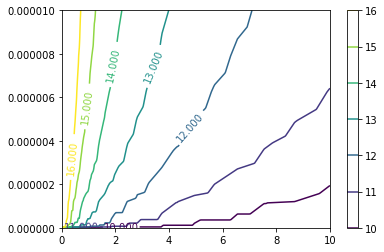

In [411]:
print (CCapInterp2(0.987654567,10**-7.34))

CP = plt.contour(XXLin,YYLin,np.log10(ZZPoints2),levels = [10,11,12,13,14,15,16])
plt.clabel(CP, inline=9, fontsize=10)
plt.colorbar()
plt.show()

## Interpolation Sanity Check

Check, $m_A = 0.01$, $\epsilon = 1.000000e-10$, $C_{Cap} = 1.371011e+13$

In [158]:
xRange = range(0,50)
yRange = range(0,gridDim)

z = []

gridstuff = np.meshgrid(mALogRange,epsilonLogRange)



# Pick an epsilon contour:
# Plot CCap vs mA for fixed epsilon with raw data and the interpolation
# Let's just say epsilon = 0.4e-10


plt.show()

# plt.axis([xMin,xMax,yMin,yMax])
# CP = plt.contour(XXLog, YYLog, ZZ)
# plt.clabel(CP, inline=1, fontsize=10)



[  0.01         0.01151395   0.01325711   0.01526418   0.01757511
   0.0202359    0.02329952   0.02682696   0.03088844   0.0355648
   0.04094915   0.04714866   0.05428675   0.06250552   0.07196857
   0.08286428   0.09540955   0.10985411   0.12648552   0.14563485
   0.16768329   0.19306977   0.22229965   0.25595479   0.29470517
   0.33932218   0.39069399   0.44984327   0.51794747   0.59636233
   0.68664885   0.79060432   0.91029818   1.04811313   1.20679264
   1.38949549   1.59985872   1.84206997   2.12095089   2.44205309
   2.8117687    3.23745754   3.72759372   4.29193426   4.94171336
   5.68986603   6.55128557   7.54312006   8.68511374  10.        ]
[  1.00000000e-10   1.26485522e-10   1.59985872e-10   2.02358965e-10
   2.55954792e-10   3.23745754e-10   4.09491506e-10   5.17947468e-10
   6.55128557e-10   8.28642773e-10   1.04811313e-09   1.32571137e-09
   1.67683294e-09   2.12095089e-09   2.68269580e-09   3.39322177e-09
   4.29193426e-09   5.42867544e-09   6.86648845e-09   8.68511374

TypeError: scatter() missing 1 required positional argument: 'y'

In [71]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed
# make up some randomly distributed data
seed(1234)
npts = 200
x = uniform(-2,2,npts)
y = uniform(-2,2,npts)
z = x*np.exp(-x**2-y**2)


print (type(x))

print ('Complete')

<class 'numpy.ndarray'>
Complete
